In [21]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'Overshoot'
    author = 'Wang_Yue'
    
    # 策略参数
    mastop = 20
    lot = 5
    period = 24
    Short = 5
    Long = 20
    
    # 策略变量
    maStop = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    Stoptracking = {} #记录量是否增长
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'mastop',
                 'period',
                 'Shortma',
                 'Longma',
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'Stoptracking',
               'transactionPrice',
               'maStop'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        if symbol not in self.Stoptracking.keys():
            self.Stoptracking[symbol] = 0.04
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.Stoptracking[symbol])
        longProfit = self.transactionPrice[symbol]*(1+5*self.Stoptracking[symbol])
        shortStop = self.transactionPrice[symbol]*(1+self.Stoptracking[symbol])
        shortProfit = self.transactionPrice[symbol]*(1-5*self.Stoptracking[symbol])
        if symbol not in self.maStop.keys():
            self.maStop[symbol] = ""
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)
            elif  (bar.close > longProfit or self.maStop[symbol]=="longstop"):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)
            elif (bar.close < shortProfit or self.maStop[symbol] == "shortstop"):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)

    #----------------------------------------------------------------------
    def on30MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am30 = self.getArrayManager(symbol, "30m")
        
        if not am30.inited:
            return
        gap = (am30.close - am30.open)/am30.open
        mu = np.mean(np.abs(gap[-self.period:]))
        std = np.std(np.abs(gap[-self.period:]))
        current = gap[-1]
        volmu = np.mean(am30.volume[-self.period:])
        volstd = np.std(am30.volume[-self.period:])
        currentvol = am30.volume[-1]
        #longma = ta.EMA(am30.close,self.longperiod)
        #angle = ta.LINEARREG_ANGLE(longma,5)
        Maarr = ta.EMA(am30.close,self.mastop)
        Mashort = ta.MA(am30.close,self.Short)
        Malong = ta.MA(am30.close,self.Long)
        #macd, signal, hist = ta.MACD(am30.close[-72:])
        if self.posDict[symbol+'_LONG'] > 0:
            if Mashort[-2]>Maarr[-2] and Mashort[-1]<Maarr[-1]:
                self.maStop[symbol] = "longstop"
        elif self.posDict[symbol+'_SHORT'] > 0:
            if Mashort[-2]<Maarr[-2] and Mashort[-1]>Maarr[-1]:
                self.maStop[symbol] = "shortstop"
        #volmu = sum(am30.volume[-self.period:])/self.period
        #volstd = np.std(am30.volume[-self.period:])
        #volcur = am30.volume[-1]
        #engulfing = max(am30.close[-1],am30.open[-1])>max(am30.close[-2],am30.open[-2]) and min(am30.close[-1],am30.open[-1])<min(am30.close[-2],am30.open[-2])
        if current>0 and (current>(mu+3*std)) and Mashort[-1]>Malong[-1] and (currentvol>(volmu+3*volstd)) and current>3*np.mean(np.abs(gap[-3:-1])):
            # 做多信号
            if  (self.posDict[symbol+'_SHORT']==0)and(self.posDict[symbol+'_LONG']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
            self.Stoptracking[symbol] = np.abs(current)*0.4
        # 做空信号
        elif current<0 and (np.abs(current)>(mu+3*std)) and Mashort[-1]<Malong[-1] and (currentvol>(volmu+3*volstd)) and np.abs(current)>3*np.mean(np.abs(gap[-3:-1])):
            if (self.posDict[symbol+'_LONG']==0)and(self.posDict[symbol+'_SHORT']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
            self.Stoptracking[symbol] = np.abs(current)*0.4
        self.putEvent()
    
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass


In [19]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=100)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('tradeDatetime')
    return perfromanceDf, tradeDf

In [9]:
#parameterDict = {'symbolList':['BTCUSDT:binance']}
#runBacktesting(MultiFrameMaStrategy, parameterDict, '20180615 12:00', '20181130 12:00', 0.002, 5/10000)

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 21:43:28.184641	开始回测
2018-12-23 21:43:28.184711	策略初始化
2018-12-23 21:43:28.581432	数据载入完成, 时间段:[20180106 08:00,20180110 12:00);数据量:6000
2018-12-23 21:43:28.581756	初始化预加载数据成功, 数据长度:6000
2018-12-23 21:43:28.581849	策略初始化完成
2018-12-23 21:43:28.581923	策略启动完成
2018-12-23 21:43:28.582081	回测时间范围:[20180110 12:00,20181210 12:00)
2018-12-23 21:43:28.582158	当前回放的时间段:[20180110 12:00,20181210 12:00)
2018-12-23 21:43:52.564319	数据载入完成, 时间段:[20180110 12:00,20181210 12:00);数据量:473509
2018-12-23 21:43:52.772560	数据载入完成, 时间段:[20180109 20:51,20180112 12:01);数据量:3790
2018-12-23 21:43:53.627763	数据载入完成, 时间段:[20171222 13:30,20180109 20:50);数据量:12645
2018-12-23 21:43:53.630573	WARNING: 该时间段:[20180112 12:01,20180112 12:30) 数据量为0!
20180110 16:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 5}
SHORT stopLoss
20180111 11:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 5}
SHORT takeProfit
20180114 13:00:00 {'BTCUSDT:

20180712 14:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 5}
SHORT takeProfit
20180716 17:30:00 {'BTCUSDT:binance_LONG': 5, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
20180718 02:00:00 {'BTCUSDT:binance_LONG': 5, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
20180727 23:30:00 {'BTCUSDT:binance_LONG': 5, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
20180730 08:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 5}
SHORT stopLoss
20180731 02:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 5}
SHORT stopLoss
20180731 17:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 5}
SHORT stopLoss
20180804 21:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 5}
SHORT takeProfit
20180807 15:30:00 {'BTCUSDT:binance_LONG': 5, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
20180808 04:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 5}
SHORT takeProfit
20180809 01:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 5}
SHORT stopLoss
20180811 05

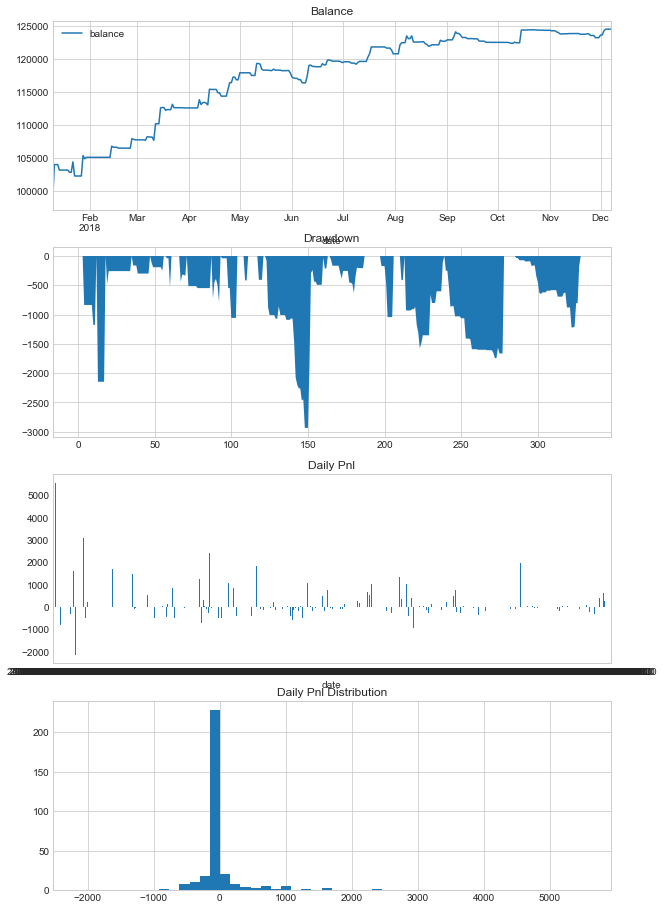

2018-12-23 21:44:49.197860	计算回测结果
2018-12-23 21:44:49.219223	------------------------------
2018-12-23 21:44:49.219352	第一笔交易：	2018-01-10 16:35:00
2018-12-23 21:44:49.219413	最后一笔交易：	2018-12-04 13:57:00
2018-12-23 21:44:49.219470	总交易次数：	148
2018-12-23 21:44:49.219535	总盈亏：	24,561.74
2018-12-23 21:44:49.219618	最大回撤: 	-2,935.15
2018-12-23 21:44:49.219808	平均每笔盈利：	165.96
2018-12-23 21:44:49.219869	平均每笔滑点：	0.02
2018-12-23 21:44:49.219942	平均每笔佣金：	37.13
2018-12-23 21:44:49.219986	胜率		38.51%
2018-12-23 21:44:49.220025	盈利交易平均值	769.2
2018-12-23 21:44:49.220062	亏损交易平均值	-211.9
2018-12-23 21:44:49.220100	盈亏比：	3.63


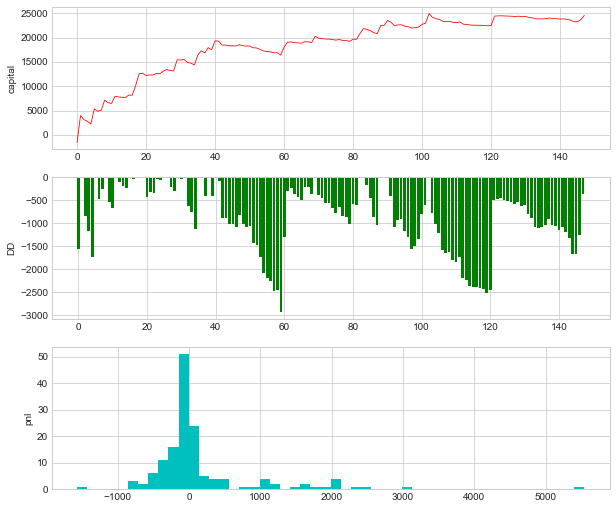

2018-12-23 21:44:50.046388	计算按日统计结果


(                 netPnl  slippage  commission   turnover  tradeCount  \
 date                                                                   
 2018-01-10 -1567.270000      0.02   67.250000  134500.00           2   
 2018-01-11  5539.782325      0.02   64.847675  129695.35           2   
 2018-01-12     0.000000      0.00    0.000000       0.00           0   
 2018-01-13     0.000000      0.00    0.000000       0.00           0   
 2018-01-14  -835.703475      0.02   68.533475  137066.95           2   
 2018-01-15     0.000000      0.00    0.000000       0.00           0   
 2018-01-16     0.000000      0.00    0.000000       0.00           0   
 2018-01-17     0.000000      0.00    0.000000       0.00           0   
 2018-01-18     0.000000      0.00    0.000000       0.00           0   
 2018-01-19     0.000000      0.00    0.000000       0.00           0   
 2018-01-20  -340.954825      0.02   61.584825  123169.65           2   
 2018-01-21     0.000000      0.00    0.000000     

In [20]:
parameterDict = {'symbolList':['BTCUSDT:binance']}
runBacktesting(MultiFrameMaStrategy, parameterDict, '20180110 12:00', '20181210 12:00', 0.002, 5/10000)

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2018-12-23 21:46:11.662602	开始回测
2018-12-23 21:46:11.662868	策略初始化
2018-12-23 21:46:12.050412	数据载入完成, 时间段:[20180606 08:00,20180610 12:00);数据量:6000
2018-12-23 21:46:12.050683	初始化预加载数据成功, 数据长度:6000
2018-12-23 21:46:12.050745	策略初始化完成
2018-12-23 21:46:12.050784	策略启动完成
2018-12-23 21:46:12.050916	回测时间范围:[20180610 12:00,20181130 12:00)
2018-12-23 21:46:12.051211	当前回放的时间段:[20180610 12:00,20181130 12:00)
2018-12-23 21:46:27.640052	数据载入完成, 时间段:[20180610 12:00,20181130 12:00);数据量:245168
2018-12-23 21:46:27.839705	数据载入完成, 时间段:[20180609 20:51,20180612 12:01);数据量:3790
2018-12-23 21:46:28.876368	数据载入完成, 时间段:[20180522 13:30,20180609 20:50);数据量:17750
2018-12-23 21:46:28.880425	WARNING: 该时间段:[20180612 12:01,20180612 12:30) 数据量为0!
20180611 01:30:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 5}
SHORT takeProfit
20180612 21:00:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 5}
SHORT stopLoss
20180613 03:30:00 {'EOSUSDT:

2018-12-23 21:46:57.087760	回放结束ress: 100%    
2018-12-23 21:46:57.087889	计算按日统计结果
2018-12-23 21:46:57.115305	------------------------------
2018-12-23 21:46:57.115797	首个交易日：	2018-06-10 00:00:00
2018-12-23 21:46:57.115838	最后交易日：	2018-11-28 00:00:00
2018-12-23 21:46:57.115870	总交易日：	172
2018-12-23 21:46:57.115901	盈利交易日	35
2018-12-23 21:46:57.115933	亏损交易日：	37
2018-12-23 21:46:57.115963	起始资金：	100000
2018-12-23 21:46:57.116035	结束资金：	100,017.28
2018-12-23 21:46:57.116104	总收益率：	0.02%
2018-12-23 21:46:57.116172	年化收益：	0.02%
2018-12-23 21:46:57.116227	总盈亏：	17.28
2018-12-23 21:46:57.116329	最大回撤: 	-1.89
2018-12-23 21:46:57.116500	百分比最大回撤: -0.0%
2018-12-23 21:46:57.116684	总手续费：	2.35
2018-12-23 21:46:57.116726	总滑点：	1.58
2018-12-23 21:46:57.116779	总成交金额：	4,698.79
2018-12-23 21:46:57.116891	总成交笔数：	158
2018-12-23 21:46:57.116946	日均盈亏：	0.1
2018-12-23 21:46:57.116999	日均手续费：	0.01
2018-12-23 21:46:57.117050	日均滑点：	0.01
2018-12-23 21:46:57.117127	日均成交金额：	27.32
2018-12-23 21:46:57.117177	日均成交笔数：	0.92
2018-12-2

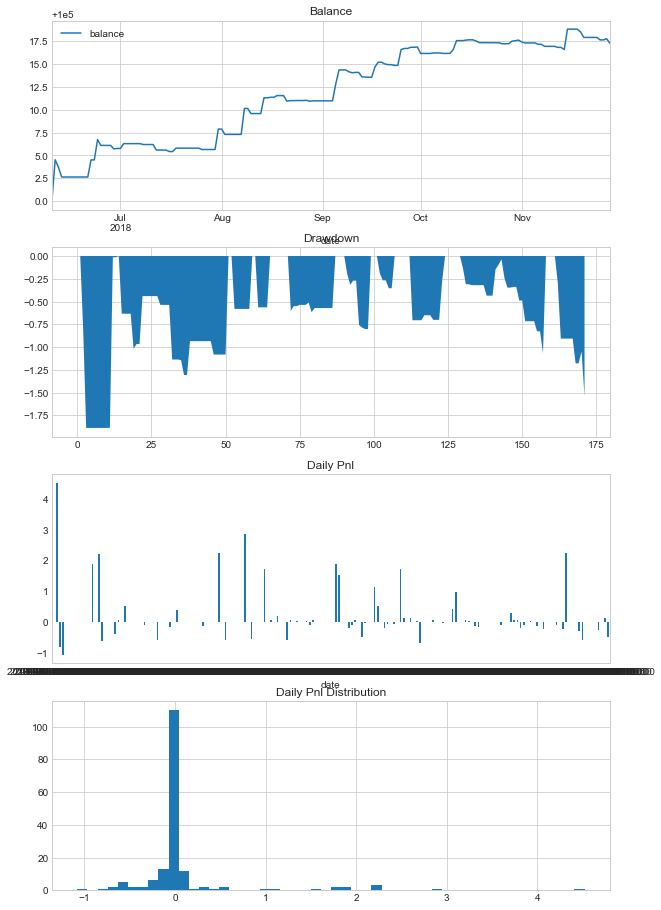

2018-12-23 21:46:59.458900	计算回测结果
2018-12-23 21:46:59.474291	------------------------------
2018-12-23 21:46:59.474441	第一笔交易：	2018-06-11 05:24:00
2018-12-23 21:46:59.474505	最后一笔交易：	2018-11-28 13:01:00
2018-12-23 21:46:59.474632	总交易次数：	79
2018-12-23 21:46:59.474712	总盈亏：	17.28
2018-12-23 21:46:59.474805	最大回撤: 	-2.03
2018-12-23 21:46:59.474908	平均每笔盈利：	0.22
2018-12-23 21:46:59.475106	平均每笔滑点：	0.02
2018-12-23 21:46:59.475170	平均每笔佣金：	0.03
2018-12-23 21:46:59.475225	胜率		44.3%
2018-12-23 21:46:59.475280	盈利交易平均值	0.88
2018-12-23 21:46:59.475342	亏损交易平均值	-0.31
2018-12-23 21:46:59.475395	盈亏比：	2.85


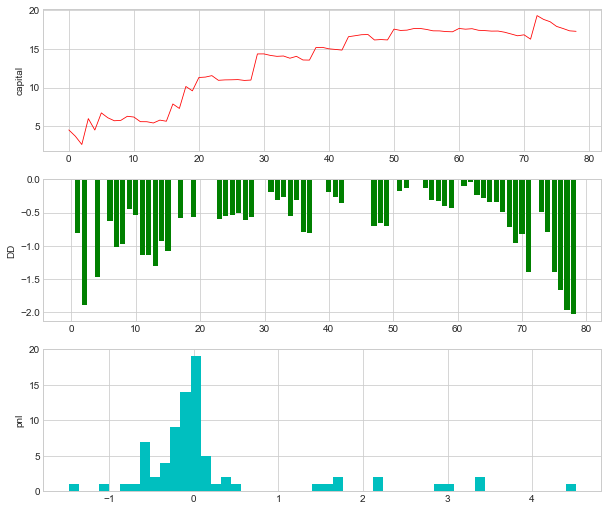

2018-12-23 21:47:00.216932	计算按日统计结果


(              netPnl  slippage  commission  turnover  tradeCount  tradingPnl  \
 date                                                                           
 2018-06-10  0.000000      0.00    0.000000    0.0000           0      0.0000   
 2018-06-11  4.519500      0.02    0.060000  120.0005           2      4.5995   
 2018-06-12 -0.811426      0.02    0.054426  108.8520           2     -0.7370   
 2018-06-13 -1.077647      0.02    0.051147  102.2935           2     -1.0065   
 2018-06-14  0.000000      0.00    0.000000    0.0000           0      0.0000   
 2018-06-15  0.000000      0.00    0.000000    0.0000           0      0.0000   
 2018-06-16  0.000000      0.00    0.000000    0.0000           0      0.0000   
 2018-06-17  0.000000      0.00    0.000000    0.0000           0      0.0000   
 2018-06-18  0.000000      0.00    0.000000    0.0000           0      0.0000   
 2018-06-19  0.000000      0.00    0.000000    0.0000           0      0.0000   
 2018-06-20  0.000000      0

In [22]:
parameterDict = {'symbolList':['EOSUSDT:binance']}
runBacktesting(MultiFrameMaStrategy, parameterDict, '20180610 12:00', '20181130 12:00', 0.002, 5/10000)

In [77]:
''''if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine

    # 创建回测引擎对象
    engine = BacktestingEngine()

    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180415 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181130 12:00') # 设置回测用的数据终止日期

    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiFrameMaStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()''''

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12d3bc1e0>, <__main__.MultiFrameMaStrategy object at 0x12c3bd278>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12d3bc268>, <__main__.MultiFrameMaStrategy object at 0x12c3bd278>)
2018-12-16 21:31:43.398557	开始回测
2018-12-16 21:31:43.398652	策略初始化
2018-12-16 21:31:43.400633	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-16 21:31:44.057639	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:31:44.060857	载入完成，数据量：12000
2018-12-16 21:31:44.061336	策略初始化完成
2018-12-16 21:31:44.061386	策略启动完成
2018-12-16 21:31:44.061475	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-16 21:31:44.087515	载入历史数据。数据范围:[20180615 12:00,20181130 12:00)
2018-12-16 21:31:59.353566	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:31:59.428755	载入完成，数据量：240128
2018-12-16 21:31:59.429179

In [78]:
''''from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('period', 24, 72, 24)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('Shortma', 3, 7, 2)    # 增加第二个优化参数，起始60，结束30，步进10
setting.addParameter('Longma', 8, 14, 2)    # 增加第二个优化参数，起始10，结束30，步进5
setting.addParameter('mastop', 10, 30, 10)

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
#resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))'''

2018-12-16 21:38:07.357218	------------------------------
2018-12-16 21:38:07.357474	setting: {'period': 24, 'Shortma': 3, 'Longma': 8, 'mastop': 10, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12d38e6a8>, <__main__.MultiFrameMaStrategy object at 0x12d1fce10>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12d38e620>, <__main__.MultiFrameMaStrategy object at 0x12d1fce10>)
2018-12-16 21:38:07.378675	开始回测
2018-12-16 21:38:07.378765	策略初始化
2018-12-16 21:38:07.380368	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-16 21:38:07.940837	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:38:07.944670	载入完成，数据量：12000
2018-12-16 21:38:07.945104	策略初始化完成
2018-12-16 21:38:07.945154	策略启动完成
2018-12-16 21:38:07.945230	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-16 21:38:0

2018-06-20 21:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT takeProfit
2018-06-24 06:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-25 01:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-25 20:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-06-25 22:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-29 06:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-06-30 06:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-30 07:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-07-01 23:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT':

2018-11-02 05:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-11-02 21:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-11-03 17:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-11-05 00:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-11-06 16:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-11-07 08:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-11-08 11:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss39:22.672264	Progress: 87%    
2018-11-09 00:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-11-09 18:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT takeProfit:22.908577	Progress: 88%    
2018-11-12 00:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT takeProfit
2018-11-14 18

2018-08-09 01:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-08-09 22:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-08-10 20:30:00.164499	Progress: 33%     {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-08-11 05:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss39:51.360715	Progress: 34%    
2018-08-12 01:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-08-16 00:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-08-17 18:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-08-18 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-08-20 05:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-08-21 06:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-08-22 09:30:00 

[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180615120000
2018-12-16 21:40:19.924528	载入历史数据。数据范围:[20180614 20:51,20180617 12:01)
2018-12-16 21:40:20.133085	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:40:20.135575	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180615102100 , 20180615120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180615120000
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180615120000
2018-12-16 21:40:20.162665	载入历史数据。数据范围:[20180527 13:30,20180614 20:50)
2018-12-16 21:40:21.440323	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:40:21.447693	载入完成，数据量：26360
2018-12-16 21:40:21.452072	载入历史数据。数据范围:[20180617 12:01,20180617 12:30)
2018-12-16 21:40:21.456589	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:40:21.456664	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', '

2018-07-08 07:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-07-09 07:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-07-10 18:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT takeProfit:06.542234	Progress: 15%    
2018-07-12 14:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT takeProfit
2018-07-13 08:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-07-15 17:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-07-16 17:30:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-07-18 02:00:00 {'BTCUSDT:binance_LONG': 20, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-07-23 05:30:00 791948	Progress: 22%    {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT stopLoss
2018-07-27 05:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 20}
SHORT takeProfit
2018-07-27 23:30:00 {

KeyboardInterrupt: 

In [38]:
'''import pandas as pd

pd.DataFrame(resultList).sort_values(1,  ascending=False)'''

,0,1,2
0,"[{'period': 72, 'longperiod': 60, 'mugap': 0.0...",2.011787,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
1,"[{'period': 72, 'longperiod': 60, 'mugap': 0.1...",2.011787,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
2,"[{'period': 48, 'longperiod': 60, 'mugap': 0.0...",1.778877,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
3,"[{'period': 48, 'longperiod': 60, 'mugap': 0.1...",1.778877,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
4,"[{'period': 48, 'longperiod': 80, 'mugap': 0.0...",1.774070,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
5,"[{'period': 48, 'longperiod': 80, 'mugap': 0.1...",1.774070,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
6,"[{'period': 72, 'longperiod': 40, 'mugap': 0.0...",1.631729,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
7,"[{'period': 72, 'longperiod': 40, 'mugap': 0.1...",1.631729,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
9,"[{'period': 72, 'longperiod': 80, 'mugap': 0.1...",1.548619,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."
8,"[{'period': 72, 'longperiod': 80, 'mugap': 0.0...",1.548619,"{'startDate': 2018-06-15 00:00:00, 'endDate': ..."


仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiFrameMaStrategy.on30MinBar at 0x12f9c5f28>, <__main__.MultiFrameMaStrategy object at 0x12e80b3c8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12fa0fa60>, <__main__.MultiFrameMaStrategy object at 0x12e80b3c8>)
2018-12-13 14:49:12.484700	开始回测
2018-12-13 14:49:12.484767	策略初始化
2018-12-13 14:49:12.487278	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-13 14:49:13.119405	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:49:13.122945	载入完成，数据量：12000
2018-12-13 14:49:13.123392	策略初始化完成
2018-12-13 14:49:13.123450	策略启动完成
2018-12-13 14:49:13.123667	开始回放回测数据,回测范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:49:13.153098	载入历史数据。数据范围:[20180615 12:00,20181130 12:00)
2018-12-13 14:49:24.835571	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 14:49:24.911794	载入完成，数据量：240128
2018-12-13 14:49:24.912246

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613100000 , 20180615113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 6602.11, 'high': 6607.96, 'low': 6569.01, 'close': 6575.11, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 431.960732, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180613103000 , 20180615120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180615120000
2018-06-19 00:30:00 {'BTCUSDT:binance_LONG': 100, 'BTCUSDT:binance_SHORT': 0}
LONG takeProfit
2018-06-22 10:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT stopLoss
2018-06-22 15:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 100}
SHORT takeProfit
2018-06-22 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance

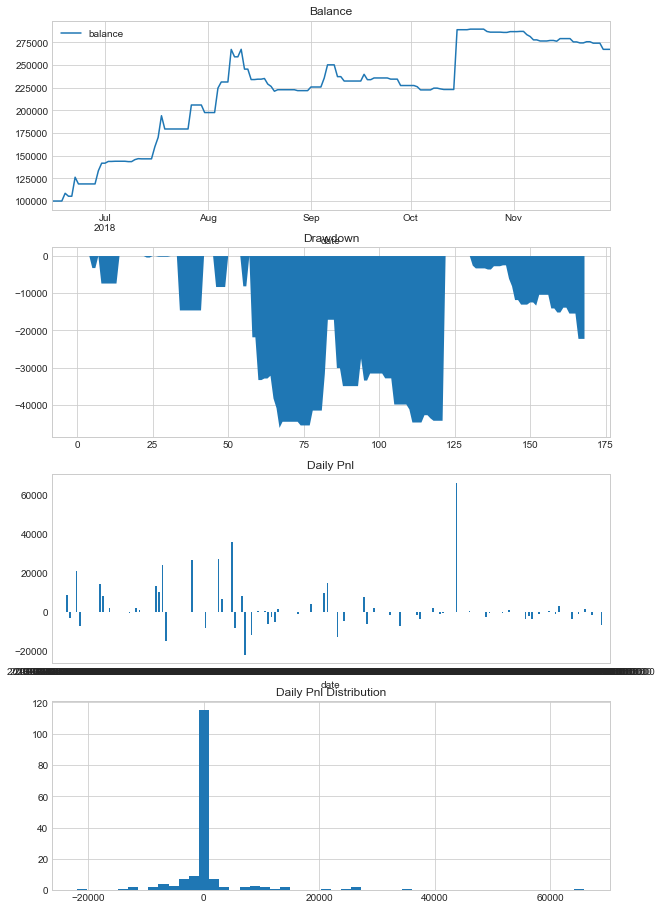

2018-12-13 14:49:54.578528	计算回测结果
2018-12-13 14:49:54.995077	------------------------------
2018-12-13 14:49:54.995284	第一笔交易：	2018-06-20 06:30:00
2018-12-13 14:49:54.995342	最后一笔交易：	2018-11-28 16:37:00
2018-12-13 14:49:54.995397	总交易次数：	72
2018-12-13 14:49:54.995457	总盈亏：	167,308.92
2018-12-13 14:49:54.995641	最大回撤: 	-46,625.02
2018-12-13 14:49:54.995695	平均每笔盈利：	2,323.74
2018-12-13 14:49:54.995776	平均每笔滑点：	0.4
2018-12-13 14:49:54.995939	平均每笔佣金：	634.14
2018-12-13 14:49:54.995996	胜率		40.28%
2018-12-13 14:49:54.996052	盈利交易平均值	11,854.08
2018-12-13 14:49:54.996128	亏损交易平均值	-4,103.71
2018-12-13 14:49:54.996301	盈亏比：	2.89


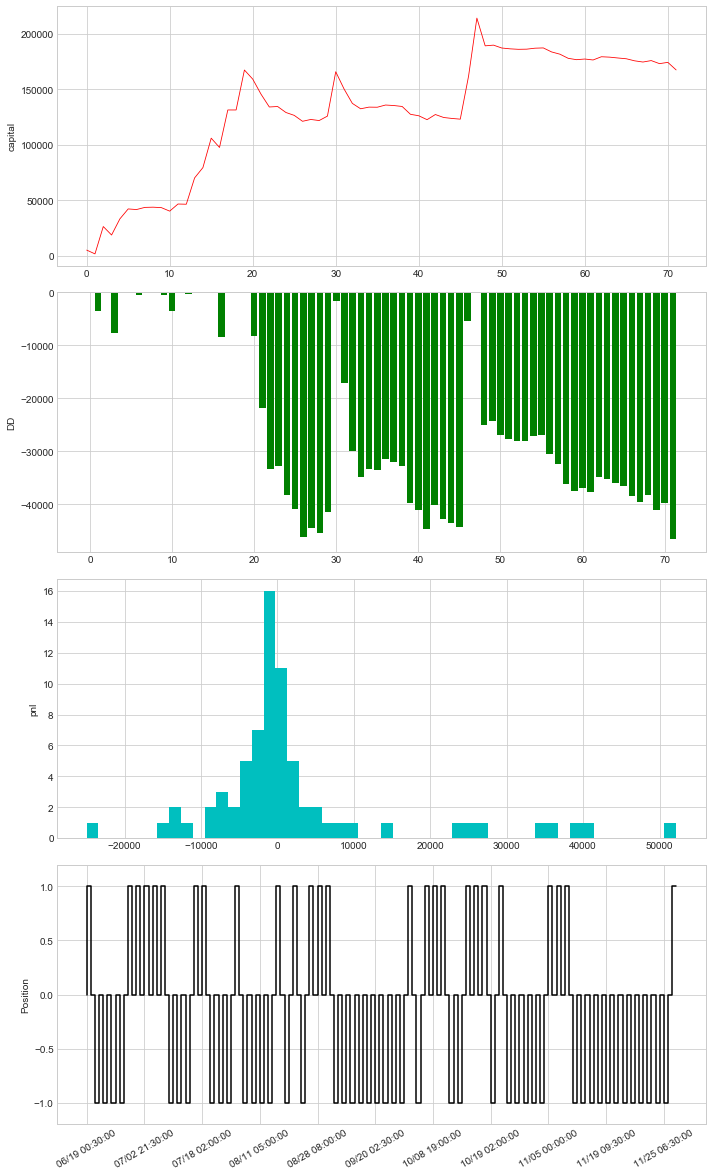

2018-12-13 14:49:56.213198	计算按日统计结果


(                netPnl  slippage  commission   turnover  tradeCount  \
 date                                                                  
 2018-06-15      0.0000       0.0      0.0000        0.0           0   
 2018-06-16      0.0000       0.0      0.0000        0.0           0   
 2018-06-17      0.0000       0.0      0.0000        0.0           0   
 2018-06-18      0.0000       0.0      0.0000        0.0           0   
 2018-06-19   8532.2805       0.2    332.5195   665039.0           1   
 2018-06-20  -3241.6990       0.2    335.4990   670998.0           1   
 2018-06-21      0.0000       0.0      0.0000        0.0           0   
 2018-06-22  20961.5275       1.0   1610.4725  3220945.0           5   
 2018-06-23  -7405.2470       0.2    311.0470   622094.0           1   
 2018-06-24      0.0000       0.0      0.0000        0.0           0   
 2018-06-25      0.0000       0.0      0.0000        0.0           0   
 2018-06-26      0.0000       0.0      0.0000        0.0        

In [40]:
#parameterDict = {'symbolList':['BTCUSDT:binance']}
#runBacktesting(MultiFrameMaStrategy, parameterDict, '20180615 12:00', '20181130 12:00', 0.002, 5/10000)